In [7]:
import os
from datetime import datetime
import time

import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb

pd.set_option('display.max_columns', 100)

In [2]:
def load_df(csv_path='input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path,
                              converters={column: json.loads for column in JSON_COLUMNS}, 
                              dtype={'fullVisitorId': 'str'}, # Important!!
                              nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    return df

In [106]:
train_data_path = 'input/train.csv'
test_data_path = 'input/test.csv'
train_df = load_df(train_data_path)
test_df = load_df(test_data_path)

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [107]:
# ラグを取るためソートする
train_df.sort_values(by=['fullVisitorId','visitNumber'], inplace=True)
test_df.sort_values(by=['fullVisitorId','visitNumber'], inplace=True)

In [108]:

train_grouped = train_df.groupby(['fullVisitorId'])
train_df['lag1_totals.hits'] = train_grouped['totals.hits'].shift(1)
train_df['lag1_totals.pageviews'] = train_grouped['totals.pageviews'].shift(1)
train_df['lag2_totals.hits'] = train_grouped['totals.hits'].shift(2)
train_df['lag2_totals.pageviews'] = train_grouped['totals.pageviews'].shift(2)

test_grouped = test_df.groupby(['fullVisitorId'])
test_df['lag1_totals.hits'] = test_grouped['totals.hits'].shift(1)
test_df['lag1_totals.pageviews'] = test_grouped['totals.pageviews'].shift(1)
test_df['lag2_totals.hits'] = test_grouped['totals.hits'].shift(2)
test_df['lag2_totals.pageviews'] = test_grouped['totals.pageviews'].shift(2)

In [112]:
target = train_df['totals.transactionRevenue'].fillna(0).astype(float)
target = target.apply(lambda x: np.log1p(x))
del train_df['totals.transactionRevenue']

In [113]:
columns = [col for col in train_df.columns if train_df[col].nunique() > 1]
#____________________________
train_df = train_df[columns]
test_df = test_df[columns]
print(columns)

['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'lag1_totals.hits', 'lag1_totals.pageviews', 'lag2_totals.hits', 'lag2_totals.pageviews']


In [114]:
trn_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df])

In [115]:
merged_df['diff_visitId_time'] = merged_df['visitId'] - merged_df['visitStartTime']
merged_df['diff_visitId_time'] = (merged_df['diff_visitId_time'] != 0).astype(int)
del merged_df['visitId']

In [116]:
del merged_df['sessionId']

In [117]:
format_str = '%Y%m%d' 
merged_df['formated_date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x), format_str))
merged_df['WoY'] = merged_df['formated_date'].apply(lambda x: x.isocalendar()[1])
merged_df['month'] = merged_df['formated_date'].apply(lambda x:x.month)
merged_df['quarter_month'] = merged_df['formated_date'].apply(lambda x:x.day//8)
merged_df['weekday'] = merged_df['formated_date'].apply(lambda x:x.weekday())

del merged_df['date']
del merged_df['formated_date']

In [118]:
merged_df['formated_visitStartTime'] = merged_df['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
merged_df['formated_visitStartTime'] = pd.to_datetime(merged_df['formated_visitStartTime'])
merged_df['visit_hour'] = merged_df['formated_visitStartTime'].apply(lambda x: x.hour)

del merged_df['visitStartTime']
del merged_df['formated_visitStartTime']

In [119]:
for col in merged_df.columns:
    if col in ['fullVisitorId', 'month', 'quarter_month', 'weekday', 'visit_hour', 'WoY']: continue
    if merged_df[col].dtypes == object or merged_df[col].dtypes == bool:
        merged_df[col], indexer = pd.factorize(merged_df[col])

train_df = merged_df[:trn_len]
test_df = merged_df[trn_len:]

In [120]:
train_df['target'] = target
train_df.head()

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,lag1_totals.hits,lag1_totals.pageviews,lag2_totals.hits,lag2_totals.pageviews,diff_visitId_time,WoY,month,quarter_month,weekday,visit_hour,target
230774,0,0000010278554503158,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,42,10,2,3,14,0.0
89784,0,0000020424342248747,1,0,0,0,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,48,11,3,2,16,0.0
683463,0,0000027376579751715,1,0,0,0,0,0,1,2,0,2,0,2,2,2,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,6,2,1,5,11,0.0
648840,1,0000039460501403861,1,0,0,0,1,0,1,3,0,3,0,1,3,3,-1,-1,-1,-1,-1,0,-1,1,0,1,-1,-1,-1,-1,0,13,3,3,0,0,0.0
683201,2,0000040862739425590,1,0,0,0,0,2,1,2,2,4,2,2,3,3,-1,0,0,0,0,1,1,2,-1,0,-1,-1,-1,-1,0,6,2,1,5,3,0.0


In [121]:
train_df.to_csv('input/train_preprocessed.csv')
test_df.to_csv('input/test_preprocessed.csv')

In [124]:
# 初回セッションと２回目以降のセッションにデータを分割する
train_df_fs = train_df[train_df['visitNumber'] == 1]
train_df_ss = train_df[train_df['visitNumber'] > 1]

# 教師データも分割
target_fs = train_df_fs['target']
target_ss = train_df_ss['target']

print("train_df_fs.shape:{}".format(train_df_fs.shape))
print("target_fs.shape:{}".format(target_fs.shape))
print("train_df_ss.shape:{}".format(train_df_ss.shape))
print("target_ss.shape:{}".format(target_ss.shape))

train_df_fs.shape:(703060, 37)
target_fs.shape:(703060,)
train_df_ss.shape:(200593, 37)
target_ss.shape:(200593,)


In [162]:
# fs でのラグは無意味なので削除
del train_df_fs['lag1_totals.hits']
del train_df_fs['lag2_totals.hits']
del train_df_fs['lag1_totals.pageviews']
del train_df_fs['lag2_totals.pageviews']

In [163]:
x_train_fs, x_val_fs, y_train_fs, y_val_fs = train_test_split(train_df_fs, target_fs, test_size=0.3, random_state=42)
print(x_train_fs.shape)
print(y_train_fs.shape)
print(x_val_fs.shape)
print(y_val_fs.shape)

(492142, 33)
(492142,)
(210918, 33)
(210918,)


In [164]:
# キーの文字列は削除
del x_train_fs['fullVisitorId']
del x_train_fs['target']
del x_val_fs['fullVisitorId']
del x_val_fs['target']

In [147]:
"""
param_fs = {
    #'n_estimators':150,
    'max_depth': 2,
    #'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'eval_metric': 'rmse',
    'subsample': 1.0,
    'reg_lambda': 1, # L2正則化 default:1
    'reg_alpha': 0, # L1正則化 default:0
}
"""
param_fs = {
    'n_estimators':150,
    'max_depth': 5,
    'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'eval_metric': 'rmse',
    'subsample': 1.0,
    'reg_lambda': 100, # L2正則化 default:1
    'reg_alpha': 0.5, # L1正則化 default:0
}

In [165]:
xgb_reg_fs = xgb.XGBRegressor(**param_fs)

In [166]:
xgb_reg_fs.fit(X=x_train_fs, y=y_train_fs)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='rmse', gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.5,
       reg_lambda=100, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

In [167]:
print('train score')
print(xgb_reg_fs.score(X=x_train_fs, y=y_train_fs))
print('val score')
print(xgb_reg_fs.score(X=x_val_fs, y=y_val_fs))

train score
0.3404364724875457
val score
0.2504343920454428


In [150]:
print('train score')
print(xgb_reg_fs.score(X=x_train_fs, y=y_train_fs))
print('val score')
print(xgb_reg_fs.score(X=x_val_fs, y=y_val_fs))

train score
0.3323500200438225
val score
0.25104889427890364


In [131]:
print('train score')
print(xgb_reg_fs.score(X=x_train_fs, y=y_train_fs))
print('val score')
print(xgb_reg_fs.score(X=x_val_fs, y=y_val_fs))

train score
0.21831252661178946
val score
0.21796414248182194


In [35]:
print('train score')
print(xgb_reg.score(X=x_train, y=y_train.values))
print('val score')
print(xgb_reg.score(X=x_val, y=y_val.values))

train score
0.3918603945675795
val score
0.31375411489859395


In [134]:
x_train_ss, x_val_ss, y_train_ss, y_val_ss = train_test_split(train_df_ss, target_ss, test_size=0.3, random_state=42)
print(x_train_ss.shape)
print(y_train_ss.shape)
print(x_val_ss.shape)
print(y_val_ss.shape)

(140415, 37)
(140415,)
(60178, 37)
(60178,)


In [136]:
# キーの文字列は削除
del x_train_ss['fullVisitorId']
del x_train_ss['target']
del x_val_ss['fullVisitorId']
del x_val_ss['target']

In [151]:
"""
param_ss = {
    #'n_estimators':150,
    'max_depth': 2,
    #'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'eval_metric': 'rmse',
    'subsample': 1.0,
    'reg_lambda': 1, # L2正則化 default:1
    'reg_alpha': 0, # L1正則化 default:0
}
"""
param_ss = {
    'n_estimators':150,
    'max_depth': 5,
    'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'eval_metric': 'rmse',
    'subsample': 1.0,
    'reg_lambda': 100, # L2正則化 default:1
    'reg_alpha': 0.5, # L1正則化 default:0
}
xgb_reg_ss = xgb.XGBRegressor(**param_ss)

In [152]:
xgb_reg_ss.fit(X=x_train_ss, y=y_train_ss)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='rmse', gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.5,
       reg_lambda=100, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

In [153]:
print('train score')
print(xgb_reg_ss.score(X=x_train_ss, y=y_train_ss))
print('val score')
print(xgb_reg_ss.score(X=x_val_ss, y=y_val_ss))

train score
0.4654068746685389
val score
0.3416875263360135


In [138]:
print('train score')
print(xgb_reg_ss.score(X=x_train_ss, y=y_train_ss))
print('val score')
print(xgb_reg_ss.score(X=x_val_ss, y=y_val_ss))

train score
0.3345068742700873
val score
0.31985516462082386


In [141]:
# 初回セッションと２回目以降のセッションにデータを分割する
test_df_fs = test_df[test_df['visitNumber'] == 1]
test_df_ss = test_df[test_df['visitNumber'] > 1]

In [142]:
submit_df_fs = pd.DataFrame(index=test_df_fs['fullVisitorId'])
submit_df_ss = pd.DataFrame(index=test_df_ss['fullVisitorId'])

del test_df_fs['fullVisitorId']
del test_df_ss['fullVisitorId']

In [154]:
submit_df_fs['PredictedLogRevenue'] = xgb_reg_fs.predict(test_df_fs)
submit_df_ss['PredictedLogRevenue'] = xgb_reg_ss.predict(test_df_ss)

submit_df = pd.concat([submit_df_fs,submit_df_ss])
print(len(submit_df))
submit_df.head()

804684


,PredictedLogRevenue
fullVisitorId,
0000000259678714014,-0.002234
0000049363351866189,0.001687
0000053049821714864,-0.007044
0000059488412965267,0.008505
0000085840370633780,0.007129


In [155]:
df_grouped = submit_df.groupby('fullVisitorId').sum()
df_grouped.head()

,PredictedLogRevenue
fullVisitorId,
0000000259678714014,0.840181
0000049363351866189,-0.013889
0000053049821714864,-0.007044
0000059488412965267,0.038236
0000085840370633780,0.007129


In [159]:
df_grouped.loc[df_grouped['PredictedLogRevenue'] < 0,'PredictedLogRevenue'] = 0

In [160]:
df_grouped.to_csv('output/submit_separate_fs_ss.csv')

In [43]:
len(df_grouped)

617242

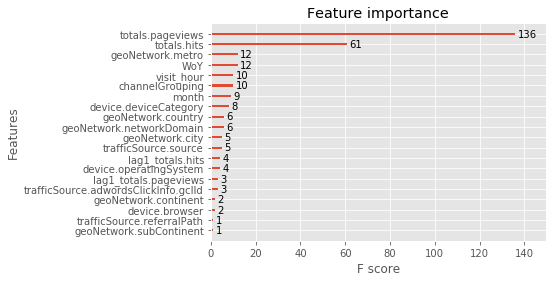

In [139]:
xgb.plot_importance(xgb_reg_fs, max_num_features=30)

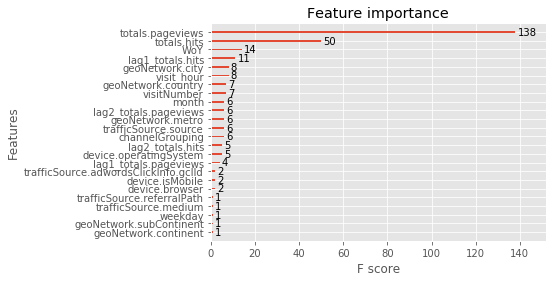

In [140]:
xgb.plot_importance(xgb_reg_ss, max_num_features=30)

In [55]:
train_df

,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,lag1_totals.hits,lag1_totals.pageviews,lag2_totals.hits,lag2_totals.pageviews,diff_visitId_time,WoY,month,quarter_month,weekday,visit_hour
230774,0,0000010278554503158,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,42,10,2,3,14
89784,0,0000020424342248747,1,0,0,0,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,48,11,3,2,16
683463,0,0000027376579751715,1,0,0,0,0,0,1,2,0,2,0,2,2,2,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,6,2,1,5,11
648840,1,0000039460501403861,1,0,0,0,1,0,1,3,0,3,0,1,3,3,-1,-1,-1,-1,-1,0,-1,1,0,1,-1,-1,-1,-1,0,13,3,3,0,0
683201,2,0000040862739425590,1,0,0,0,0,2,1,2,2,4,2,2,3,3,-1,0,0,0,0,1,1,2,-1,0,-1,-1,-1,-1,0,6,2,1,5,3
683316,2,0000040862739425590,2,0,0,0,0,2,1,2,2,4,2,2,4,4,-1,0,0,0,0,1,1,2,-1,0,0,0,-1,-1,0,6,2,1,5,3
211023,0,000005103959234087,1,0,1,1,2,0,1,2,0,2,0,2,5,0,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,33,8,2,6,7
900218,3,0000062267706107999,1,0,0,0,1,0,1,3,0,5,0,1,6,5,-1,-1,-1,-1,-1,2,-1,3,-1,2,-1,-1,-1,-1,0,27,7,1,6,9
384318,0,0000068403966359845,1,1,2,1,3,3,1,2,3,6,2,2,3,3,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,14,4,0,0,13
697376,4,0000085059828173212,1,1,1,1,3,4,1,2,4,7,3,2,6,5,-1,-1,-1,-1,-1,0,-1,4,-1,3,-1,-1,-1,-1,0,29,7,2,2,7


In [76]:
#0000436683523507380
train_df.loc[train_df['fullVisitorId'] == '6588500311054802771',
                 ['visitNumber', 'totals.hits', 'lag1_totals.hits', 'lag2_totals.hits',
                  'totals.pageviews', 'lag1_totals.pageviews', 'lag2_totals.pageviews']]

,visitNumber,totals.hits,lag1_totals.hits,lag2_totals.hits,totals.pageviews,lag1_totals.pageviews,lag2_totals.pageviews
458254,1,18,NaN,NaN,16,NaN,NaN
741822,2,1,18,NaN,1,16,NaN
740344,3,9,1,18,7,1,16
742030,4,2,9,1,2,7,1
370663,5,1,2,9,1,2,7
370680,6,1,1,2,1,1,2
645508,7,3,1,1,3,1,1
646071,8,3,3,1,3,3,1
644577,9,13,3,3,11,3,3
646105,10,4,13,3,4,11,3


In [80]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,lag1_totals.hits,lag1_totals.pageviews,lag2_totals.hits,lag2_totals.pageviews
296886,Organic Search,20171128,0000000259678714014,0000000259678714014_1511912001,Not Socially Engaged,1511912001,1,1511912001,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Mountain View,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,3,1,3,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,NaN
298120,Organic Search,20171128,0000000259678714014,0000000259678714014_1511914780,Not Socially Engaged,1511914780,2,1511914780,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Mountain View,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,unknown.unknown,not available in demo dataset,California,Northern America,NaN,16,NaN,10,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google,3,3,NaN,NaN
287456,Direct,20170918,0000049363351866189,0000049363351866189_1505779414,Not Socially Engaged,1505779414,1,1505779414,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Gurgaon,not available in demo dataset,Asia,India,not available in demo dataset,not available in demo dataset,(not set),(not set),not available in demo dataset,Haryana,Southern Asia,1,1,1,1,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct),NaN,NaN,NaN,NaN
288297,Direct,20170918,0000049363351866189,0000049363351866189_1505796426,Not Socially Engaged,1505796426,2,1505796426,Chrome,not available in demo dataset,not available in d

In [99]:
x_train

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,lag1_totals.hits,lag1_totals.pageviews,lag2_totals.hits,lag2_totals.pageviews,diff_visitId_time,WoY,month,quarter_month,weekday,visit_hour
594356,4,1,0,1,1,2,0,2,4,0,8,0,3,13,2,-1,-1,-1,-1,-1,0,-1,4,-1,3,-1,-1,-1,-1,0,29,7,2,3,6
91659,1,1,1,0,0,0,313,2,25,1,76,227,8,6,5,-1,-1,-1,-1,-1,0,-1,1,11,1,-1,-1,-1,-1,0,48,11,3,2,11
736440,1,1,1,0,0,0,0,2,4,0,8,0,3,6,5,-1,-1,-1,-1,-1,0,-1,1,4,1,-1,-1,-1,-1,0,44,11,0,5,4
701695,0,1,0,1,1,2,57,1,7,1,210,47,2,3,3,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,45,11,1,6,23
148983,0,1,1,1,1,3,0,1,63,0,16895,0,16,6,5,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,25,6,2,3,8
128575,0,1,0,0,0,1,43,2,39,1,62,37,3,6,5,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,10,3,1,4,2
265261,0,1,0,0,0,1,0,2,8,0,10211,0,4,12,8,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,16,4,2,6,6
811818,0,3,0,0,0,0,0,4,37,0,4452,0,9,3,3,-1,-1,-1,-1,-1,0,0,0,-1,0,10,9,2,2,0,19,5,1,2,20
860074,0,1,0,1,1,2,34,4,10,7,5,28,7,0,11,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,-1,-1,-1,0,37,9,2,6,0
139887,0,1,6,0,0,0,9,1,2,5,763,7,2,12,8,-1,-1,-1,-1,-1,0,0,0,-1,9,-1,-1,-1,-1,0,12,3,2,0,8


In [169]:
df_submit = pd.read_csv('output/submit_xgboost_grid_searched.csv')
df_submit.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,-0.140034
1,0000049363351866189,-0.002930
2,0000053049821714864,-0.004992
3,0000059488412965267,0.050905
4,0000085840370633780,-0.000393


In [170]:
df_submit["PredictedLogRevenue"] = df_submit["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)

In [171]:
df_submit.to_csv('output/xgboost_grid_searched_update_neg.csv',index=False)

In [172]:
len(df_submit)

617242